In [1]:
import findspark
SPARK_HOME = %env SPARK_HOME
findspark.init(SPARK_HOME)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.titlesize': 0, 'figure.figsize' : (4,3)})

import os
from os import listdir
from functools import reduce
import sys

from pyspark.sql.dataframe import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StructField, StringType, IntegerType , BooleanType, DoubleType
from pyspark.sql.window import Window

from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.appName('yahoo').getOrCreate()
sc = spark.sparkContext

In [121]:
import mlflow
from mlflow import log_metric, log_param, log_artifact, pyfunc
from mlflow.pyfunc import PythonModel

"""
mlflow server \
    --backend-store-uri sqlite:///mlflow.db \
    --default-artifact-root ./artifacts \
    --host 0.0.0.0
"""

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("yahoo")

### File imports and EDA

In [66]:
mainpath = "yahoo_data/A2BENCHMARK/"
np.random.seed(111)
all_files = [f.name for f in os.scandir(mainpath) if f.is_file()]
test_files = np.random.choice(all_files, 30, replace=False)
[os.rename(mainpath + t, mainpath + "train/" + t) for t in  (set(all_files)-set(test_files))]
[os.rename(mainpath + t, mainpath + "test/" + t) for t in test_files]
len(test_files)

30

In [3]:
mainpath = "yahoo_data/A2BENCHMARK/"
df0 = spark.read.options(header='true', inferschema='true').csv(mainpath+"/train/synthetic_45.csv")
df0.printSchema()
df0.show(5,False)

root
 |-- timestamp: integer (nullable = true)
 |-- value: double (nullable = true)
 |-- is_anomaly: integer (nullable = true)

+----------+-----------------+----------+
|timestamp |value            |is_anomaly|
+----------+-----------------+----------+
|1416726000|-281.129226660013|0         |
|1416729600|141.363496042075 |0         |
|1416733200|-261.277613349315|0         |
|1416736800|891.936445176684 |0         |
|1416740400|377.682139002056 |0         |
+----------+-----------------+----------+
only showing top 5 rows



### Feature Engineering

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

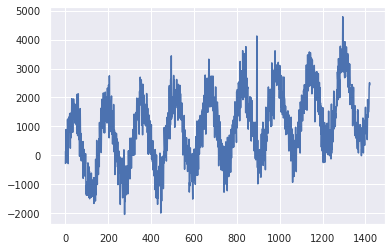

In [81]:
%matplotlib inline
npdf0 = df0.toPandas().value.to_numpy()
p = plt.plot(npdf0)

In [6]:
%matplotlib widget
import statsmodels as sm
acf, ci = sm.tsa.stattools.acf(npdf0, alpha=0.05, nlags=500)
plt.plot(acf)[0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
from scipy.signal import find_peaks
find_peaks(acf, distance=50)[0]

array([ 77, 154, 227, 316, 401, 472])

In [40]:
acf_peaks = find_peaks(acf, distance=50)[0]
acf_peaks

array([ 77, 154, 227, 316, 401, 472])

In [44]:
acf[acf_peaks]

array([-0.42976709,  0.68623087, -0.38189469,  0.55761358, -0.39064866,
        0.42418328])

In [42]:
acf_peaks[np.argmax(acf[acf_peaks])]

154

In [72]:
acf_peaks[1::2][-1]

472

In [29]:
%matplotlib inline

'''
This function finds the median of each point at a certain interval k. 

Iterates over a numpy array, finds every kth point, calculates the median, and does this for every point in the array.
This function is useful in periodic differencing when outliers are present (so the outliers do not get subtracted).
'''
def periodic_median(arr, k):
    l = arr.shape[0]
    newarr = np.array([0]*l)
    for i,e in enumerate(arr):
        indices = range(i,l+i)
        newarr[i] = np.median(arr.take(indices, mode='wrap')[::k])
    return newarr

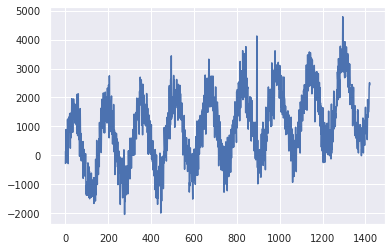

In [66]:
plt.plot(npdf0)

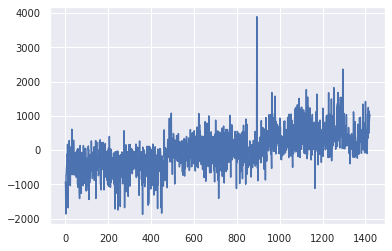

In [73]:
%matplotlib inline
k = acf_peaks[1::2][-1]
npdf0 = df0.toPandas().value.to_numpy()
sub = np.subtract(npdf0, periodic_median(npdf0, k))
plt.plot(sub)

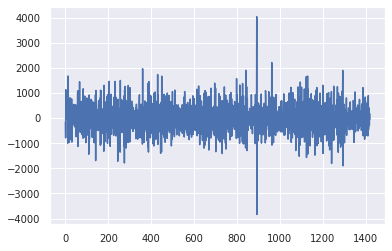

In [74]:
plt.plot(np.diff(sub))

In [80]:
len(df0.toPandas()[df0.toPandas().is_anomaly == 1])

1

In [83]:
train_dfs = [spark.read.options(header='true', inferschema='true').csv(mainpath + f"train/{csv}") for csv in os.listdir(mainpath + "train/")]
test_dfs = [spark.read.options(header='true', inferschema='true').csv(mainpath + f"test/{csv}") for csv in os.listdir(mainpath + "test/")]

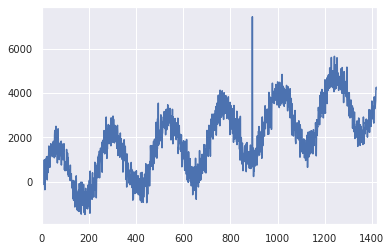

In [84]:
%matplotlib inline
train_dfs[-1].toPandas().value.plot()

In [100]:
import pandas as pd

In [104]:
@F.pandas_udf('double')
def remove_season(col):
    acf_peaks = find_peaks(acf, distance=50)[0]      #Get last maximum from acf plot
    k = acf_peaks[1::2][-1]                          #Use this maxima as season
    arr = col.to_numpy()
    sub = np.subtract(arr, periodic_median(arr, k))  #Subtract season from original array
    return pd.Series(sub)

In [107]:
df0.withColumn("sub", remove_season(F.col("value"))).limit(5).toPandas()

,timestamp,value,is_anomaly,sub
0,1416726000,-281.129227,0,-927.129227
1,1416729600,141.363496,0,-1080.636504
2,1416733200,-261.277613,0,-1866.277613
3,1416736800,891.936445,0,-735.063555
4,1416740400,377.682139,0,-703.317861


In [114]:
def prepare_df(df: DataFrame) -> DataFrame:
    
    outdf = df.withColumn("sub",  remove_season(F.col("value")))
    
    ts_window = Window.partitionBy().orderBy("timestamp")
    outdf = outdf.withColumn("value_lag1", F.lag(F.col("sub")).over(ts_window))
    outdf = (outdf.withColumn("value_diff1", F.when(F.isnull(outdf.value - outdf.value_lag1), 0)
                                              .otherwise(outdf.value - outdf.value_lag1)))
    
    #2nd difference
    outdf = outdf.withColumn("value_diff1_lag1", F.lag(F.col("value_diff1")).over(ts_window))
    outdf = (outdf.withColumn("value_diff2", F.when(F.isnull(outdf.value_diff1 - outdf.value_diff1_lag1), 0)
                                              .otherwise(outdf.value_diff1 - outdf.value_diff1_lag1)))
    
    #outdf = outdf.na.fill(0)
    # Use backfill instead of na
    bf_window = Window.orderBy('timestamp').rowsBetween(0, sys.maxsize)
    outdf = (outdf.withColumn('value_lag1', F.first(outdf['value_lag1'], ignorenulls=True).over(bf_window))
                  .withColumn('value_diff1_lag1', F.first(outdf['value_diff1_lag1'], ignorenulls=True).over(bf_window)))
                             
    quantiles = outdf.approxQuantile("value_diff1", [0.25,0.75],0.05)
    outdf = (outdf.join(outdf.agg(F.stddev(F.col("value_diff1")).alias("std")))
                  .withColumn("q1", F.lit(quantiles[0]))
                  .withColumn("q3", F.lit(quantiles[1])))
                
    quantiles = outdf.approxQuantile("value_diff2", [0.25,0.75],0.05)
    outdf = (outdf.join(outdf.agg(F.stddev(F.col("value_diff2")).alias("std2")))
              .withColumn("q1_2", F.lit(quantiles[0]))
              .withColumn("q3_2", F.lit(quantiles[1])))
    
    

    return outdf

In [115]:
prepare_df(df0).limit(3).toPandas()

,timestamp,value,is_anomaly,sub,value_lag1,value_diff1,value_diff1_lag1,value_diff2,std,q1,q3,std2,q1_2,q3_2
0,1416726000,-281.129227,0,-927.129227,-927.129227,0.000000,0.000000,0.000000,1145.052181,127.385892,1692.635774,1036.929213,-669.119811,537.791946
1,1416729600,141.363496,0,-1080.636504,-927.129227,1068.492723,0.000000,1068.492723,1145.052181,127.385892,1692.635774,1036.929213,-669.119811,537.791946
2,1416733200,-261.277613,0,-1866.277613,-1080.636504,819.358891,1068.492723,-249.133832,1145.052181,127.385892,1692.635774,1036.929213,-669.119811,537.791946


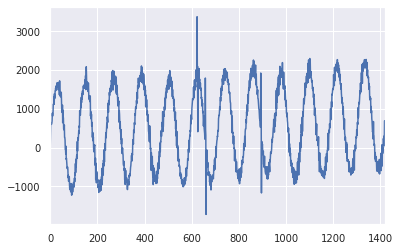

In [118]:
%matplotlib inline
prepare_df(train_dfs[45]).toPandas().value_diff1.plot()

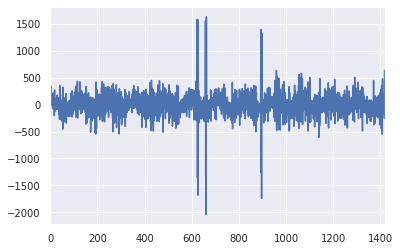

In [119]:
prepare_df(train_dfs[45]).toPandas().value_diff2.plot()

In [122]:
prepared_train_dfs = list(map(prepare_df, train_dfs))
prepared_test_dfs = list(map(prepare_df, test_dfs))
train_df = reduce(DataFrame.unionAll, prepared_train_dfs)
test_df = reduce(DataFrame.unionAll, prepared_test_dfs)

### Model Definition and udf wrapping

In [147]:
def predict_from_quants(value_diff1: float, q1: float, q3: float, value_diff2: float, q1_2: float, q3_2: float) -> float:
    threshold, threshold2 = (3.4, 1.5)
    Q1, Q1_2 = (float(q1), float(q1_2))
    Q3, Q3_2 = (float(q3), float(q3_2))
    IQR, IQR_2 = (Q3 - Q1, Q3_2 - Q1_2)
    if (float(value_diff1) < (Q1 - IQR*threshold) or float(value_diff1) > Q3 + IQR*threshold or
        float(value_diff2) < (Q1_2 - IQR_2*threshold2) or float(value_diff2) > Q3_2 + IQR_2*threshold2):
        return 1.0
    else:
        return 0.0

class UDFWrapper(PythonModel):
    def __init__(self, estimator=None):
        return None
    def predict(self, context, X):
        return np.array(predict_from_quants(*X.to_numpy().T))

In [148]:
from typing import Callable

def apply_prediction(df: DataFrame, prediction_function: Callable, columns):
    return df.withColumn("prediction", F.udf(prediction_function, DoubleType())(*columns))

# Load model from registry
def apply_prediction_saved(df: DataFrame, model_path: str = "models:/yahoo_model_quant/Staging", columns = ["value_diff1", "q1", "q3"]):
    prediction_udf = mlflow.pyfunc.spark_udf(spark, model_path)
    return df.withColumn('prediction', prediction_udf(*columns))

In [125]:
apply_prediction(prepare_df(df0), predict_from_quants, ["value_diff1", "q1", "q3", "value_diff2", "q1_2", "q3_2"]).limit(3).toPandas()

,timestamp,value,is_anomaly,sub,value_lag1,value_diff1,value_diff1_lag1,value_diff2,std,q1,q3,std2,q1_2,q3_2,prediction
0,1416726000,-281.129227,0,-927.129227,-927.129227,0.000000,0.000000,0.000000,1145.052181,127.385892,1692.635774,1036.929213,-669.119811,537.791946,0.0
1,1416729600,141.363496,0,-1080.636504,-927.129227,1068.492723,0.000000,1068.492723,1145.052181,127.385892,1692.635774,1036.929213,-669.119811,537.791946,0.0
2,1416733200,-261.277613,0,-1866.277613,-1080.636504,819.358891,1068.492723,-249.133832,1145.052181,127.385892,1692.635774,1036.929213,-669.119811,537.791946,0.0


In [25]:
apply_prediction_saved(prepare_df(df0)).limit(3).toPandas()

,timestamp,value,is_anomaly,value_lag1,value_diff1,value_diff1_lag1,value_diff2,std,q1,q3,std2,q1_2,q3_2,prediction
0,1416726000,13.894031,0,13.894031,0.000000,0.000000,0.000000,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,0.0
1,1416729600,33.578274,0,13.894031,19.684242,0.000000,19.684242,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,0.0
2,1416733200,88.933746,0,33.578274,55.355473,19.684242,35.671230,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,0.0


In [149]:
evaluator = BinaryClassificationEvaluator().setRawPredictionCol("prediction").setLabelCol("is_anomaly")
result = evaluator.evaluate(apply_prediction(test_df, predict_from_quants, ["value_diff1", "q1", "q3", "value_diff2", "q1_2", "q3_2"]))
print(result)
log_artifact("yahoo.ipynb", "jup_logs")
log_param("type", "quantile_deseason")
log_param("na_fill_type", "backfill")
log_param("threshold1", str(3.4))
log_param("threshold2", str(1.5))
log_metric("AreaUnderROC", result)

"""
Currently, loading the model after saving it ends the run. In order to associate the current model with its params, I'm logging it again.
The consequences of this are that useful model versions iterate by 2, and every other experiment run is empty
"""
mlflow.pyfunc.log_model(
            python_model=UDFWrapper(),
            registered_model_name="yahoo_model_deseason",
            artifact_path="yahoo_models"
        )
mlflow.end_run()

0.8769673027092945


Registered model 'yahoo_model_deseason' already exists. Creating a new version of this model...
Created version '9' of model 'yahoo_model_deseason'.
